## Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. 

This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through persistent checkpointing. 

If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. 

When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that checkpointing is much more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. 

But lets not get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

To get started, create a `MemorySaver` checkpointer.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

**Note:** we're using an in-memory checkpointer. This is convenient for our tutorial (it saves it all in-memory). 

In a production application, you should change this to use `SqliteSaver` or `PostgresSaver` and connect to your own DB.

Next define the graph. Now that you've already built your own `BasicToolNode`, we'll replace it with LangGraph's prebuilt `ToolNode` and `tools_condition`, since these do some nice things like parallel API execution. 


Apart from that, the following is all copied from Part 2 above.

In [ ]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]
# llm = ChatOllama(model="llama3.2")
# llm = ChatGroq(model="mixtral-8x7b-32768")
llm = ChatOpenAI(model="gpt-4o-mini")

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.set_entry_point("chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_edge(START, "chatbot")


Finally, compile the graph with the provided checkpointer.

In [ ]:
graph = graph_builder.compile(checkpointer=memory)

Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the State as the graph works through each node.

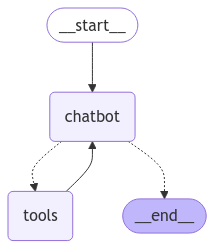

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [ ]:
config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [ ]:
user_input = "Hi there! My name is Malik."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Hi there! My name is Malik.
================================== Ai Message ==================================

Hi Malik! It's great to meet you. How can I assist you today?


Let's ask a followup: see if it remembers your name.

In [ ]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Malik! How can I assist you today, Malik?


Here is what happens if you using a different config.

In [ ]:
user_input = "Remember my name?"

# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I'm sorry, but I don't have the ability to remember personal information or names from previous interactions. How can I assist you today?


**Note:** That the only change we've made is to modify the `thread_id` in the config. 

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? 


To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Malik.', additional_kwargs={}, response_metadata={}, id='b3a7d6a2-d164-4f8a-b73a-cc2041aa81ff'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-11-28T20:40:35.264994Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'information about current events and news'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 3024792250, 'load_duration': 821738500, 'prompt_eval_count': 194, 'prompt_eval_duration': 1909000000, 'eval_count': 26, 'eval_duration': 292000000}, id='run-e7e9b046-fade-464e-a91e-546d14ff8783-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'information about current events and news'}, 'id': '8f822f3e-5c01-487a-9b05-02bd7bc8b6b2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 194, 'output_tokens': 26, 'total_tokens

In [ ]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

The snapshot above contains the current state values, corresponding config, and the next node to process. In our case, the graph has reached an END state, so next is empty.

In [ ]:
config = {"configurable": {"thread_id": "2"}}
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='f23bf930-299d-4f6e-9e00-2b4df62e3a51'), AIMessage(content="I'm sorry, but I don't have the ability to remember personal information or names from previous interactions. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 83, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-542327d4-1798-4a46-a421-049951b12080-0', usage_metadata={'input_tokens': 83, 'output_tokens': 27, 'total_tokens': 110, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'a

In [ ]:
snapshot.next

()

In the next part, we'll introduce human oversight to our bot to handle situations where it may need guidance or verification before proceeding.